In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint
from datetime import datetime

sys.path.append('../..')

In [37]:
# from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent
from model.amm.trade_strategies import general_arbitrage, invest_all
from model.amm.global_state import GlobalState
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.exchange import Exchange
from model import run
import model.plot_utils as pu

class CEXDummy(Exchange):
    def __init__(self, tokens: dict[str: float], unique_id='dummy exchange'):
        super().__init__()
        self.prices = tokens
        self.liquidity = {tkn: 0 for tkn in tokens}
        self.asset_list = list(tokens.keys())
        self.unique_id = unique_id

    def price(self, tkn: str, denomination: str = ''):
        if denomination and denomination not in self.prices:
            raise ValueError(f'Denomination {denomination} not in exchange')
        return self.prices[tkn] / (self.prices[denomination] if denomination in self.prices else 1)

    def buy_spot(self, tkn_buy, tkn_sell, fee=0):
        return self.price(tkn_buy) / self.price(tkn_sell)

    def sell_spot(self, tkn_sell, tkn_buy, fee=0):
        return self.price(tkn_sell) / self.price(tkn_buy)

    def buy_limit(self, tkn_buy, tkn_sell):
        return float('inf')

    def sell_limit(self, tkn_buy, tkn_sell):
        return float('inf')
    
    def swap(
            self,
            agent: Agent,
            tkn_buy: str,
            tkn_sell: str,
            buy_quantity: float = 0,
            sell_quantity: float = 0
    ):
        if buy_quantity:
            sell_quantity = self.calculate_sell_from_buy(tkn_buy, tkn_sell, buy_quantity)
        elif sell_quantity:
            buy_quantity = self.calculate_buy_from_sell(tkn_buy, tkn_sell, sell_quantity)

        if tkn_buy not in agent.holdings:
            agent.holdings[tkn_buy] = 0

        agent.holdings[tkn_sell] -= sell_quantity
        agent.holdings[tkn_buy] += buy_quantity
        self.liquidity[tkn_sell] += sell_quantity
        self.liquidity[tkn_buy] -= buy_quantity

    def calculate_buy_from_sell(self, tkn_buy, tkn_sell, sell_quantity):
        return sell_quantity * self.price(tkn_sell) / self.price(tkn_buy)

    def calculate_sell_from_buy(self, tkn_sell, tkn_buy, buy_quantity):
        return buy_quantity * self.price(tkn_buy) / self.price(tkn_sell)

rebase_amount = 1000        
def rebase(tkn: str):
    def evolve(state: GlobalState):
        tkn_holders = {
            pool: pool.liquidity[tkn]
            for pool in state.pools.values()
        }
        tkn_holders.update({
            agent: agent.holdings[tkn]
            for agent in state.agents.values()
        })
        total_supply = sum(tkn_holders.values())
        awards = 0
        for holder in tkn_holders:
            if isinstance(holder, Agent):
                awards += rebase_amount * holder.holdings[tkn] / total_supply
                holder.holdings[tkn] += rebase_amount * holder.holdings[tkn] / total_supply
            elif isinstance(holder, Exchange):
                awards += rebase_amount * holder.liquidity[tkn] / total_supply
                holder.liquidity[tkn] += rebase_amount * holder.liquidity[tkn] / total_supply
        if (state.time_step % 100 == 0):
            print(total_supply)
            print(awards)
        return state
    return evolve

binance = CEXDummy({'S1': 1, 'S2': 1}, 'binance')
stableswap = StableSwapPoolState(
    tokens={'S1': 1000000, 'S2': 1000000},
    amplification=10,
    trade_fee=0.001,
    unique_id='stableswap'
)
LP = Agent(
    holdings={'S1': rebase_amount},
    trade_strategy=invest_all('stableswap'),
    unique_id='LP'
)
non_LP = Agent(
    holdings={'S1': rebase_amount},
    trade_strategy=None,
    unique_id='non_LP'
)
arbitrageur = Agent(
    holdings={'S1': 1000000, 'S2': 1000000},
    trade_strategy=general_arbitrage([stableswap, binance], config=[{'exchanges': {'stableswap': ('S1', 'S2'), 'binance': ('S1', 'S2')}, 'buffer': 0}])
)
initial_state = GlobalState(
    pools={'stableswap': stableswap, 'binance': binance},
    agents={'LP': LP, 'non_LP': non_LP, 'arbitrageur': arbitrageur},
    external_market={'S1': 1, 'S2': 1},
    evolve_function=rebase('S1')
)

In [45]:
events = run.run(initial_state, time_steps=2000)

Starting simulation...
2101000.0000000047
1000.0000000000002
2200999.999999999
999.9999999999999
2300999.9999999925
1000.0
2400999.999999988
1000.0
2500999.9999999823
1000.0
2600999.999999976
1000.0
2700999.9999999707
1000.0
2800999.9999999627
1000.0
2900999.9999999553
1000.0
3000999.9999999497
1000.0
3100999.999999942
1000.0
3200999.9999999423
999.9999999999999
3300999.9999999413
1000.0000000000001
3400999.9999999385
1000.0
3500999.999999933
1000.0
3600999.9999999264
1000.0
3700999.999999923
1000.0
3800999.99999992
1000.0
3900999.9999999143
1000.0
4000999.999999908
1000.0
Execution time: 8.152 seconds.


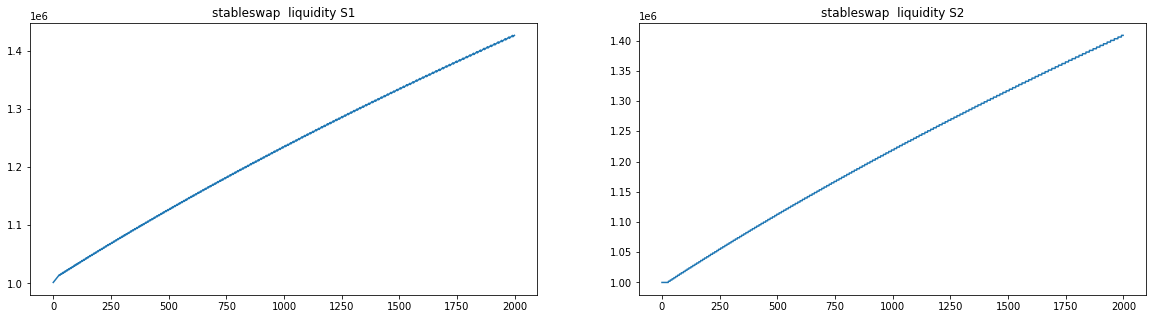

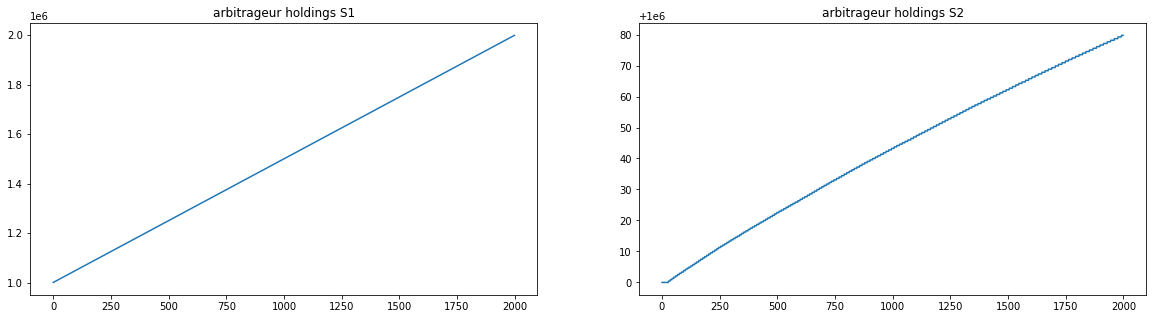

In [46]:
pu.plot(events, pool='stableswap', prop='liquidity')
pu.plot(events, agent='arbitrageur', prop='holdings', key=['S1', 'S2'])

In [47]:
impermanent_loss = [
    (1 - event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market)
    / sum(event.agents['non_LP'].holdings.values())) * 100
    for event in events
]
total_supply = [
    sum([
        event.pools['stableswap'].liquidity['S1'], 
        event.agents['arbitrageur'].holdings['S1'], 
        event.agents['LP'].holdings['S1'], 
        event.agents['non_LP'].holdings['S1']
    ]) for event in events
]


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

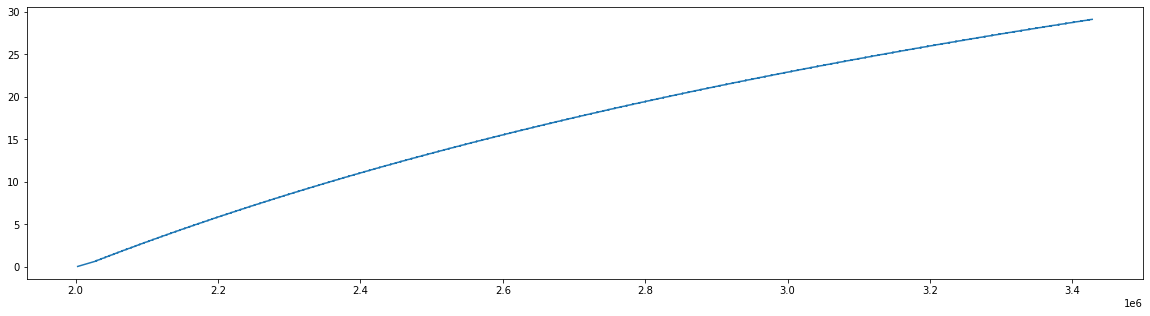

In [48]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, impermanent_loss)
plt.title

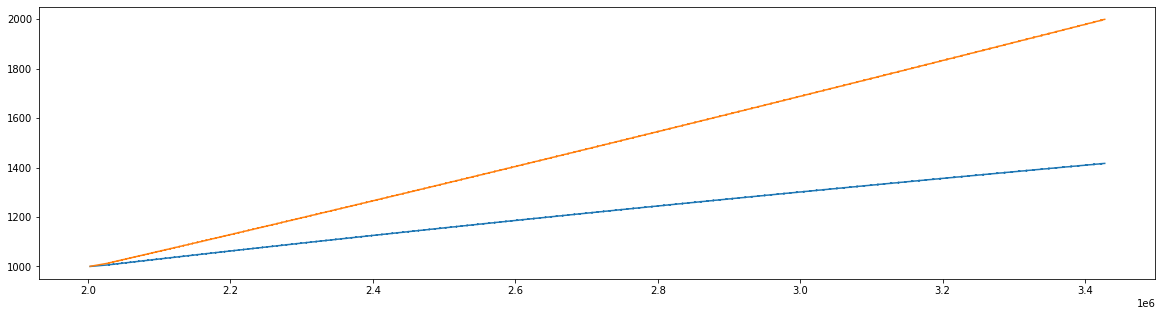

In [50]:
plt.figure(figsize=(20, 5))
plt.plot(total_supply, [event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market) for event in events])
plt.plot(total_supply, [sum(event.agents['non_LP'].holdings.values()) for event in events])

In [51]:
events[-1].agents['non_LP'].holdings['S1']

1999.0009990010549

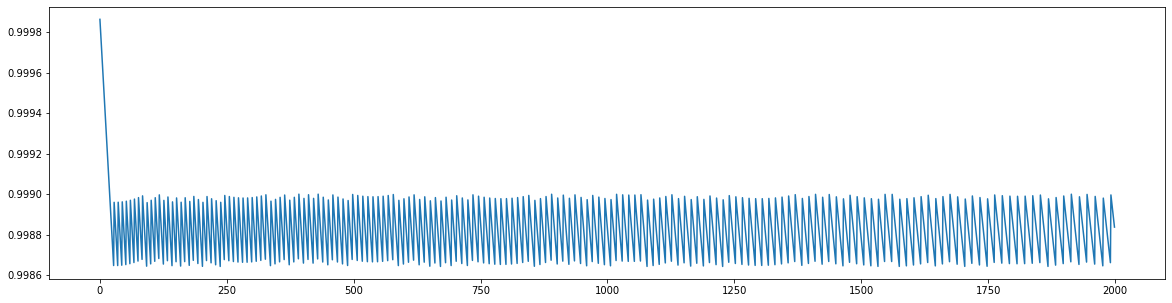

In [52]:
plt.figure(figsize=(20, 5))
plt.plot([event.pools['stableswap'].price('S1', 'S2') for event in events])

In [53]:
event = events[-1]
print(event.pools['stableswap'].cash_out(event.agents['LP'], event.external_market))

1416.592232209322


In [54]:
stablepool = event.pools['stableswap']
agent = event.agents['LP']

share_fraction = agent.holdings[stablepool.unique_id] / stablepool.shares
delta_tkns = {tkn: share_fraction * stablepool.liquidity[tkn] for tkn in stablepool.asset_list}  # delta_tkn is positive
print(delta_tkns)
# print([delta_tkns[tkn] * prices[tkn] for tkn in stablepool.asset_list])

{'S1': 712.8285046562819, 'S2': 703.7637275530402}


In [55]:
agent.holdings['stableswap']

999.7042730715858

In [56]:
stablepool.shares

2000999.7042730716

In [57]:
print(event.agents['arbitrageur'].holdings)

{'S1': 1999000.999000866, 'S2': 1000079.7404091728, 'USD': 0}
